In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from dysh.fits.gbtfitsload import GBTFITSLoad

In [41]:
path = "/home/scratch/psalas/support/UMD-py/examples"
case_dir = f"{path}/onoff-L/"
raw_sdfits = f"{case_dir}/data/TGBT21A_501_11.raw.vegas.fits"
cal_sdfits = f"{case_dir}/outputs/NGC2415_HI.fits"

In [6]:
sdf = GBTFITSLoad(raw_sdfits)

==SDFITSLoad /home/scratch/psalas/support/UMD-py/examples/onoff-L//data/TGBT21A_501_11.raw.vegas.fits


doing pandas for HDU 1
==GBTLoad /home/scratch/psalas/support/UMD-py/examples/onoff-L//data/TGBT21A_501_11.raw.vegas.fits
0 OBJECT: ['NGC2415']
0 SCAN: [152, 153]
0 SAMPLER: ['A1_0', 'A2_0', 'A1_1', 'A2_1', 'A1_2', 'A2_2', 'A1_3', 'A2_3', 'A1_4', 'A2_4']
0 SIG: ['T']
0 CAL: ['F', 'T']
0 PROCSEQN: [1, 2]
0 PROCSIZE: [2]
0 OBSMODE: ['OnOff:PSWITCHON:TPWCAL', 'OnOff:PSWITCHOFF:TPWCAL']
0 SIDEBAND: ['L']


In [7]:
psscan = sdf.getps(152)

PSSCAN nrows = 302


In [8]:
psscan.calibrate()

In [29]:
exp_ref_on = psscan._sdfits.index(psscan._bintable_index).iloc[psscan._refonrows]["EXPOSURE"].to_numpy()
exp_ref_off = psscan._sdfits.index(psscan._bintable_index).iloc[psscan._refoffrows]["EXPOSURE"].to_numpy()
exp_sig_on = psscan._sdfits.index(psscan._bintable_index).iloc[psscan._sigonrows]["EXPOSURE"].to_numpy()
exp_sig_off = psscan._sdfits.index(psscan._bintable_index).iloc[psscan._sigoffrows]["EXPOSURE"].to_numpy()

In [30]:
exp_ref = 0.5*(exp_ref_on + exp_ref_off)
exp_sig = 0.5*(exp_sig_on + exp_sig_off)
exposure = 0.5*(exp_ref + exp_sig)

In [31]:
dnu_ref_on = psscan._sdfits.index(psscan._bintable_index).iloc[psscan._refonrows]["CDELT1"].to_numpy()
dnu_ref_off = psscan._sdfits.index(psscan._bintable_index).iloc[psscan._refoffrows]["CDELT1"].to_numpy()
dnu_sig_on = psscan._sdfits.index(psscan._bintable_index).iloc[psscan._sigonrows]["CDELT1"].to_numpy()
dnu_sig_off = psscan._sdfits.index(psscan._bintable_index).iloc[psscan._sigoffrows]["CDELT1"].to_numpy()

In [32]:
dnu_ref = 0.5*(dnu_ref_on + dnu_ref_off)
dnu_sig = 0.5*(dnu_sig_on + dnu_sig_off)
dnu = 0.5*(dnu_ref + dnu_sig)

In [36]:
weight = abs(dnu)*exposure*np.power(psscan._tsys, -2.)

In [39]:
avg = np.average(psscan._calibrated, weights=weight)

In [43]:
cal_sdf = GBTFITSLoad(cal_sdfits)
ta_idl = cal_sdf._bintable[0].data["DATA"][0]

==SDFITSLoad /home/scratch/psalas/support/UMD-py/examples/onoff-L//outputs/NGC2415_HI.fits
doing pandas for HDU 1
==GBTLoad /home/scratch/psalas/support/UMD-py/examples/onoff-L//outputs/NGC2415_HI.fits
0 OBJECT: ['NGC2415']
0 SCAN: [152]
0 SAMPLER: ['A2_0']
0 SIG: ['T']
0 CAL: ['F']
0 PROCSEQN: [1]
0 PROCSIZE: [2]
0 OBSMODE: ['OnOff:PSWITCHON:TPWCAL']
0 SIDEBAND: ['L']


In [45]:
diff = avg - ta_idl

0.00058327947
0.0006081015


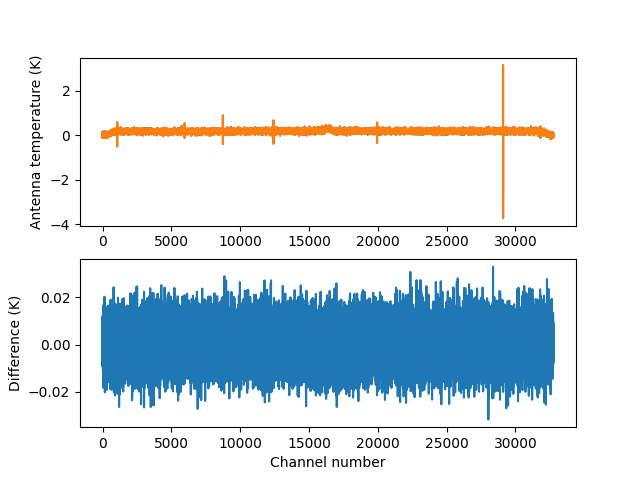

In [48]:
plt.figure()
plt.subplot(211)
plt.plot(avg)
plt.plot(ta_idl)
plt.ylabel("Antenna temperature (K)")
plt.subplot(212)
plt.plot(diff)
plt.ylabel("Difference (K)")
plt.xlabel("Channel number")
print(np.nanmean(diff))
print(np.nanmedian(diff))

The mean and median of the difference are smaller than if we do not use weights, but it is still larger than the machine floating point precision. Maybe there's something going on with adjusting the data values to account for Doppler tracking in `GBTIDL`.